In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

from utils import (
    amino_acid_codes, get_equilibrium_probabilities, 
    prepare_aa_subst, prepare_exp_aa_subst, plot_aa_eq_freqs,
    get_equilibrium_freqs, get_equilibrium_freqs_rnd
)

In [2]:
mitomap_pathogenic = pd.read_csv('external_datasets/ConfirmedMutations_MITOMAP_Foswiki.csv')
mitomap_pathogenic = mitomap_pathogenic[(mitomap_pathogenic['Locus Type'] == "Coding") & 
                                        (mitomap_pathogenic['Locus'] != "MT-ND6") &
                                        (mitomap_pathogenic['aaΔ-or-RNA'].str.match('[A-Z][0-9]{1,4}[A-Z]$'))]
mitomap_pathogenic['aa1'] = mitomap_pathogenic['aaΔ-or-RNA'].str[0]
mitomap_pathogenic['aa2'] = mitomap_pathogenic['aaΔ-or-RNA'].str[-1]
mitomap_pathogenic

,Index,Locus Type,Locus,Associated Diseases,Allele,Position,aaΔ-or-RNA,Status ♣(Mitomap [ClinGen]),Last StatusUpdate,aa1,aa2
24,25,Coding,MT-ND1,LHON MELAS overlap,m.3376G>A,3376,E24K,Cfrm [VUS*],2022.08.11,E,K
25,26,Coding,MT-ND1,LHON,m.3460G>A,3460,A52T,Cfrm [P],2023.04.25,A,T
26,27,Coding,MT-ND1,MELAS / Progressive Encephalomyopathy,m.3481G>A,3481,E59K,Cfrm [LP],2023.09.26,E,K
28,29,Coding,MT-ND1,LHON,m.3635G>A,3635,S110N,Cfrm [LP],2022.08.23,S,N
29,30,Coding,MT-ND1,Leigh Syndrome,m.3688G>A,3688,A128T,Cfrm [LP],2023.12.21,A,T
30,31,Coding,MT-ND1,MELAS / Leigh Syndrome / LDYT / BSN,m.3697G>A,3697,G131S,Cfrm [LP],2022.08.11,G,S
31,32,Coding,MT-ND1,LHON,m.3700G>A,3700,A132T,Cfrm [VUS*],2022.04.13,A,T
32,33,Coding,MT-ND1,LHON,m.3733G>A,3733,E143K,Cfrm [VUS*],2022.08.11,E,K
33,34,Coding,MT-ND1,Progressive Encephalomyopathy / Leigh Syndrome...,m.3890G>A,3890,R195Q,Cfrm [LP],2022.08.11,R,Q
35,36,Coding,MT-ND1,MELAS,m.3946G>A,3946,E214K,Cfrm [LP],2024.03.18,E,K


In [3]:
spectra_human_megatree = pd.read_csv(
    './external_datasets/human_megatree_genes_spectra.csv', index_col=0)
spectra_human_megatree

,Mut,ObsNum,ExpNum,MutSpec,MutSpec_q05,MutSpec_median,MutSpec_q95
Gene,,,,,,,
ATP6,A>C,4.82915,49.0,0.001958,0.000683,0.001606,0.003860
ATP6,A>G,493.37400,79.0,0.124053,0.115703,0.123299,0.133501
ATP6,A>T,14.66790,49.0,0.005946,0.003896,0.005667,0.008291
ATP6,C>A,25.38110,49.0,0.010289,0.007022,0.010073,0.013041
ATP6,C>G,6.78884,49.0,0.002752,0.000820,0.002442,0.004783
...,...,...,...,...,...,...,...
ND6,G>C,8.63618,33.0,0.003704,0.001667,0.003699,0.006256
ND6,G>T,3.70384,33.0,0.001589,0.000000,0.001592,0.003013
ND6,T>A,5.91110,31.0,0.002699,0.000898,0.002691,0.004454


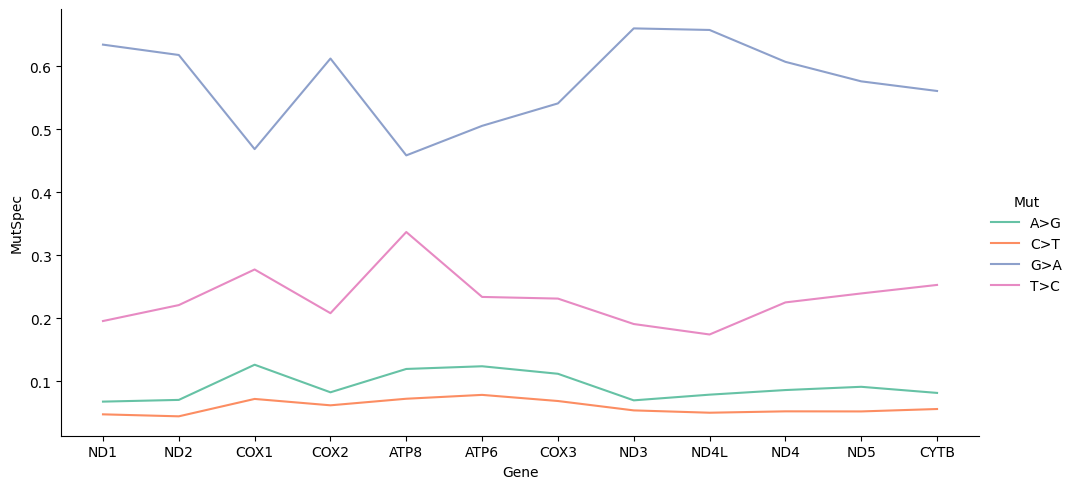

In [5]:
genes_order = ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3',
       'ND3', 'ND4L', 'ND4', 'ND5', 'CYTB']

sns.relplot(spectra_human_megatree.loc[genes_order].reset_index(), 
            hue='Mut', y='MutSpec',
            x='Gene', palette='Set2',
            height=5, aspect=2,
            kind='line', hue_order=['A>G', 'C>T', 'G>A', 'T>C'],
            )

## Derive equilibium for each gene

In [6]:
exp_aa_subst, exp_aa_subst_matrix = prepare_exp_aa_subst(
    spectra_human_megatree.loc['CYTB'], 'MutSpec', gc=2)

In [7]:
import matplotlib

my_palette = sns.diverging_palette(12, 255, s=100, sep=50, as_cmap=True)

matplotlib.colormaps.register(my_palette, name="RedBlue3")

/tmp/ipykernel_120339/879058697.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(diff.sort_values(ascending=False).reset_index(),


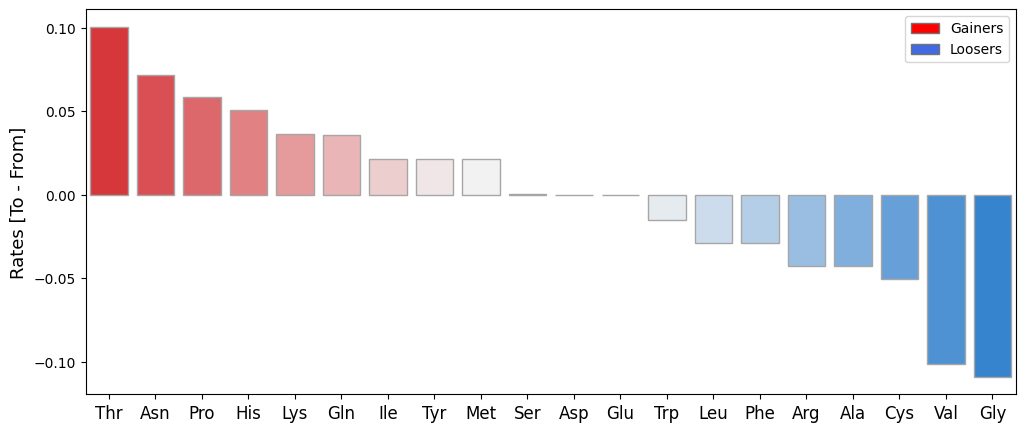

aa
Ala   -0.042988
Arg   -0.042472
Asn    0.072009
Asp   -0.000098
Cys   -0.050514
Gln    0.035928
Glu   -0.000224
Gly   -0.109114
His    0.050711
Ile    0.021593
Leu   -0.028682
Lys    0.036373
Met    0.021325
Phe   -0.028823
Pro    0.058630
Ser    0.000713
Thr    0.100638
Trp   -0.015273
Tyr    0.021494
Val   -0.101225
dtype: float64

In [8]:
def plot_aa_eq_freqs(exp_aa_subst_matrix, save_path: str, show=True, figsize=(12, 3)):
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

    _freqs_to = (freqs_to / freqs_to.sum()).copy()
    _freqs_from = (freqs_from / freqs_from.sum()).copy()
    _freqs_to.index.name = 'aa'
    _freqs_from.index.name = 'aa'

    diff = _freqs_to - _freqs_from

    plt.figure(figsize=figsize)
    ax = sns.barplot(diff.sort_values(ascending=False).reset_index(), 
                x='aa', y=0, palette='RedBlue3', edgecolor=".65")

    plt.legend([
        plt.Rectangle((0,0),1,1,fc="Red", edgecolor = '0.45'), 
        plt.Rectangle((0,0),1,1,fc='royalblue', edgecolor = '0.45'),
        ],['Gainers', 'Loosers'], 
        loc='upper right')

    # plt.title(f'Expected aa subst based assignment')
    plt.ylabel('Rates [To - From]', fontsize=13)
    plt.xlabel('')
    plt.xticks(fontsize=12)
    plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close()
    
    return diff

plot_aa_eq_freqs(exp_aa_subst_matrix, save_path='/tmp/aa', 
                 show=True, figsize=(12, 5))

In [9]:
# Create a palette with 12 shades of gray and 1 red
colors = ['#808080'] * 12 + ['#FF0000']
custom_palette = LinearSegmentedColormap.from_list("GrayRed", colors, N=13)

# Register the palette
matplotlib.colormaps.register(name="GrayRed", cmap=custom_palette)

In [10]:
lg_data = []
for gene in spectra_human_megatree.index.unique():
    cur_sp = spectra_human_megatree.loc[gene]
    _, exp_aa_subst_matrix = prepare_exp_aa_subst(
        cur_sp, 'MutSpec', gc=2)
    cur_diff = plot_aa_eq_freqs(exp_aa_subst_matrix, save_path='/tmp/aa', 
                    show=False, figsize=(12, 5))
    lg_data.append(cur_diff.rename('flow').reset_index().assign(gene=gene))
lg_df = pd.concat(lg_data, ignore_index=True)
lg_df

/tmp/ipykernel_120339/879058697.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(diff.sort_values(ascending=False).reset_index(),
/tmp/ipykernel_120339/879058697.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(diff.sort_values(ascending=False).reset_index(),
/tmp/ipykernel_120339/879058697.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(diff.sort_values(ascending=False).reset_index(),
/tmp/ipykernel_120339/879058697.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remove

,aa,flow,gene
0,Ala,-0.034894,ATP6
1,Arg,-0.034279,ATP6
2,Asn,0.057925,ATP6
3,Asp,-0.000267,ATP6
4,Cys,-0.040478,ATP6
...,...,...,...
255,Ser,-0.003776,ND6
256,Thr,-0.073906,ND6
257,Trp,0.036069,ND6
258,Tyr,0.025689,ND6


In [11]:
lg_df.query('gene == "CYTB"').sort_values('flow', ascending=False).aa

116    Thr
102    Asn
114    Pro
108    His
111    Lys
105    Gln
109    Ile
118    Tyr
112    Met
115    Ser
103    Asp
106    Glu
117    Trp
110    Leu
113    Phe
101    Arg
100    Ala
104    Cys
119    Val
107    Gly
Name: aa, dtype: object

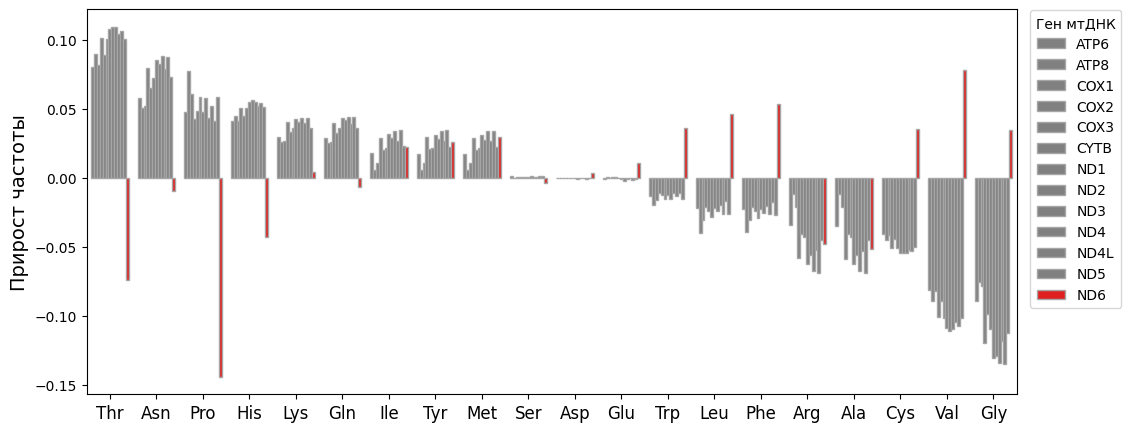

In [12]:
plt.figure(figsize=(12, 5))
sns.barplot(
    lg_df, x='aa', y='flow', hue='gene', 
    palette='GrayRed', edgecolor=".65",
    order=lg_df.query('gene == "CYTB"').sort_values('flow', ascending=False).aa,
)
plt.legend(
    loc='upper right', bbox_to_anchor=(1.12, 1.015), title='Ген мтДНК', fontsize=10)
plt.ylabel('Прирост частоты', fontsize=14)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.savefig('./aa_flow_by_gene_megatree.pdf', bbox_inches='tight')
plt.show()

## Apply neutral model genes-wise

In [13]:
from Bio import SeqIO

refseq = SeqIO.parse('NC_012920.1.gb', 'genbank')
refseq = list(refseq)[0]

In [14]:
from collections import Counter

aa_freqs = dict()
for fea in refseq.features:
    if fea.type == 'CDS':
        # print(fea.qualifiers['gene'])
        # print(fea.qualifiers['translation'])
        # print('---')
        aa_freqs[fea.qualifiers['gene'][0]] = dict(Counter(fea.qualifiers['translation'][0]))

In [15]:
pd.DataFrame(aa_freqs).T.fillna(0).astype(int).rename(columns=amino_acid_codes)

,Met,Pro,Ala,Asn,Leu,Ile,Val,Phe,Thr,Glu,Arg,Lys,Gly,Tyr,Gln,Asp,Ser,Trp,His,Cys
ND1,16,22,27,13,63,23,10,16,35,11,7,7,12,14,6,4,21,9,2,0
ND2,25,23,20,20,64,31,8,15,43,6,4,12,13,10,10,0,28,11,4,0
COX1,32,29,40,17,62,38,36,41,34,10,8,10,46,22,6,15,32,16,18,1
COX2,10,15,14,7,33,22,13,10,21,11,6,4,11,9,7,11,10,4,6,3
ATP8,6,11,0,5,10,3,1,1,8,1,0,7,0,2,3,0,4,3,2,1
ATP6,12,14,19,11,44,29,8,9,26,3,4,6,8,3,7,1,13,3,6,0
COX3,11,13,15,6,34,14,13,23,24,7,5,3,19,11,9,3,21,12,17,1
ND3,8,8,8,4,28,9,3,8,7,5,1,3,3,3,3,3,6,4,0,1
ND4L,10,2,9,6,23,7,6,3,5,2,1,0,4,4,1,1,8,0,3,3
ND4,27,23,26,23,96,39,13,20,48,9,9,11,17,13,10,3,43,13,13,3


In [16]:
obs = pd.read_csv('external_datasets/raw_human_megatree.csv')
obs = obs[(obs.TypeRef == 'CDS') & (obs.Label == 0)]\
    .rename(columns={'Aa1': 'aa1', 'Aa2': 'aa2', 'ProbaFull': 'count'})
obs.groupby('GeneRef')['count'].sum()#.reset_index().sort_values('ProbaFull', ascending=False)

GeneRef
ATP6    3055.092665
ATP8     472.123497
COX1    1709.687863
COX2    1078.190504
COX3    1369.232015
CYTB    3187.932690
ND1     2029.938575
ND2     1551.558796
ND3      558.732994
ND4     1489.099940
ND4L     196.110239
ND5     3462.016167
ND6     1049.286695
Name: count, dtype: float64

In [17]:
obs[obs.GeneRef == 'ND6']

,Mut,Cxt1,Cxt2,Site,ProbaRef,ProbaMut,count,RefNode,AltNode,SiteRef,...,TypeRef,GeneRef,PosInGeneRef,PosInCodonRef,CodonRef,NucMsaRef,Label,aa1,aa2,sbs12
424,A[T>C]A,AATAT,AACAT,15295,0.848346,0.826855,0.448335,Node49539,Node49540,14178,...,CDS,ND6,496,1,ATT,T,0,I,V,T>C
425,G[C>T]A,AGCAA,AGTAA,15326,0.345842,0.279990,0.151815,Node49539,Node49540,14208,...,CDS,ND6,466,1,ACT,T,0,V,I,C>T
427,A[C>T]A,AACAG,AATAG,15375,0.359918,0.295683,0.160324,Node49539,Node49540,14256,...,CDS,ND6,418,1,ATT,T,0,V,I,C>T
436,A[C>T]T,TACTA,TATTA,15633,0.368214,0.303281,0.164444,Node49539,Node49540,14514,...,CDS,ND6,160,1,ATA,T,0,E,K,C>T
437,C[C>T]A,GCCAA,GCTAA,15690,0.343526,0.278355,0.150929,Node49539,Node49540,14571,...,CDS,ND6,103,1,AGC,T,0,V,I,C>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116790,A[G>A]T,CAGTA,CAATA,15325,1.000000,1.000000,0.999978,Node4268,S2670N,14207,...,CDS,ND6,467,2,ACT,G,0,S,L,G>A
117032,G[C>T]A,AGCAA,AGTAA,15280,1.000000,1.000000,0.999996,Node4458,S4847N,14163,...,CDS,ND6,511,1,GCT,C,0,V,I,C>T
117078,C[C>T]A,ACCAA,ACTAA,15304,0.999990,0.999990,0.999984,Node4005,S46627N,14187,...,CDS,ND6,487,1,GGT,C,0,V,I,C>T
117122,A[G>A]C,GAGCA,GAACA,15279,1.000000,1.000000,0.996470,Node262,S6105N,14162,...,CDS,ND6,512,2,GCT,G,0,S,L,G>A


In [23]:
metrics = pd.read_csv('./megatree_fit_metrics.csv', index_col=0)\
    [['slope', 'r2', 'rmse', 'spearman_corr', 'mut_count']]
metrics

,slope,r2,rmse,spearman_corr,mut_count
gene,,,,,
ATP6,0.402208,0.435900,0.014438,0.626212,3055.090
ATP8,0.170362,-0.006339,0.023014,0.226069,472.123
COX1,0.406556,0.346571,0.013576,0.441875,1709.690
COX2,0.365792,0.410098,0.018394,0.580945,1078.190
COX3,0.311134,0.283773,0.017958,0.516008,1369.230
CYTB,0.384002,0.390545,0.016380,0.652193,3187.930
ND1,0.305885,0.098915,0.018362,0.532908,2029.940
ND2,0.307874,0.331778,0.021094,0.455085,1551.560
ND3,0.244365,0.162405,0.024365,0.252634,558.733


In [24]:
metrics.corr('spearman')

,slope,r2,rmse,spearman_corr,mut_count
slope,1.000000,0.895604,-0.884615,0.653846,0.741758
r2,0.895604,1.000000,-0.648352,0.736264,0.587912
rmse,-0.884615,-0.648352,1.000000,-0.571429,-0.785714
spearman_corr,0.653846,0.736264,-0.571429,1.000000,0.741758
mut_count,0.741758,0.587912,-0.785714,0.741758,1.000000


<Axes: >

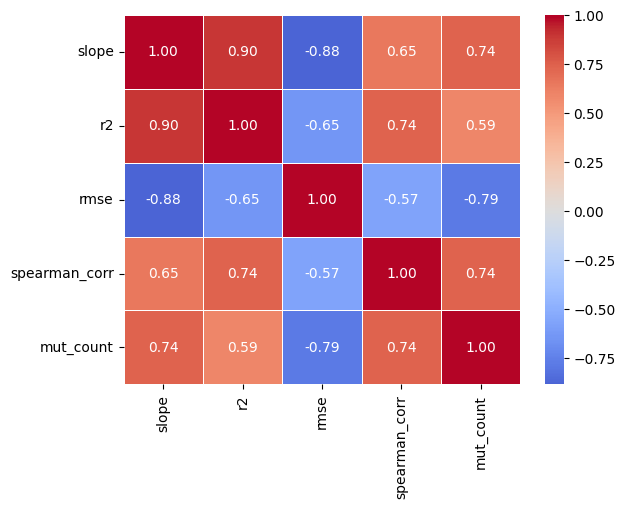

In [25]:
sns.heatmap(metrics.corr('spearman'), 
            cmap='coolwarm', center=0, annot=True, fmt='.2f', linewidths=.5)

## compare obs and eq aa freqs

In [26]:
def plot_obs_vs_eq_aa_freqs(
        freqs_aa, title='', save_path=None, show=True
    ):
    plt.figure(figsize=(14, 4))
    ax = sns.barplot(freqs_aa, x='aa', y='eq_freq', color='lightgray', 
                    edgecolor=".55", label='Equilibrium', alpha=0.5)
    sns.barplot(data=freqs_aa, x='aa', y='obs_freq', alpha=0.5, 
                ax=ax, label='Observed', color='lightgreen',
                edgecolor=".55",)
    ax.set_title(title)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xlabel('Amino acid', fontsize=14)
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    return ax

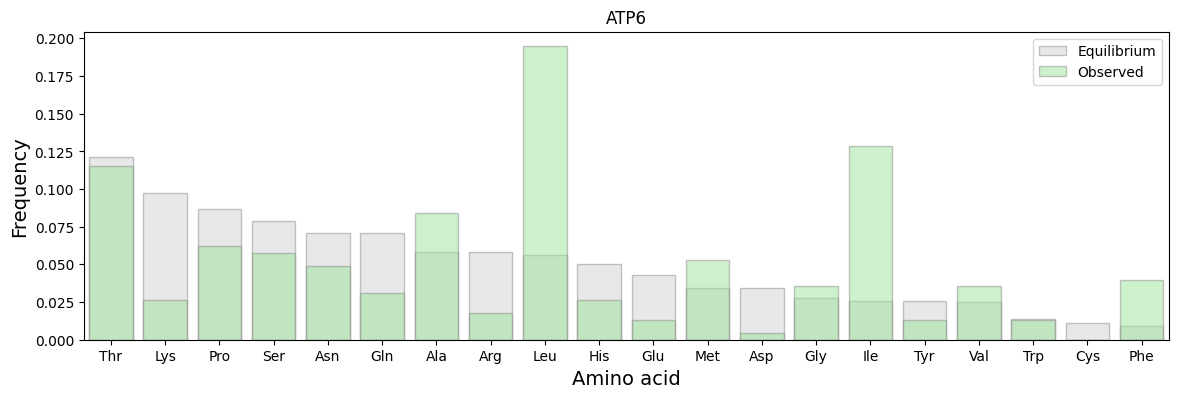

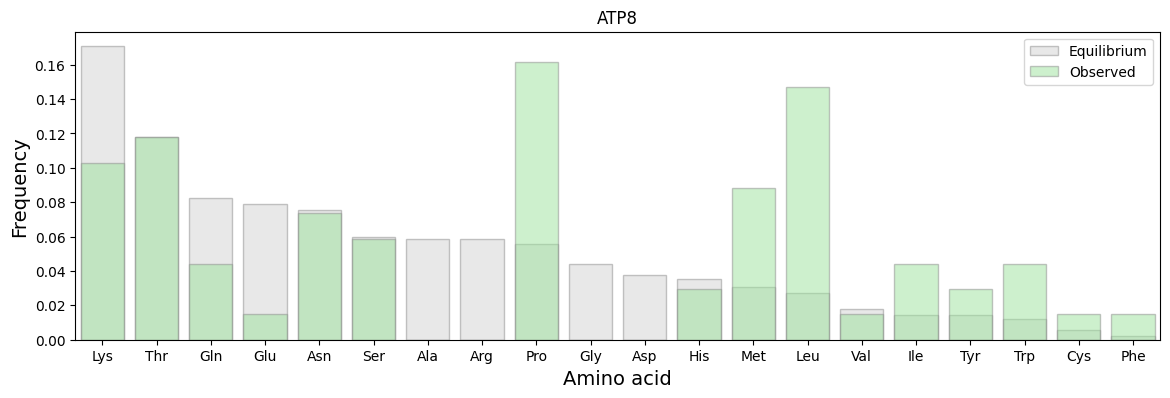

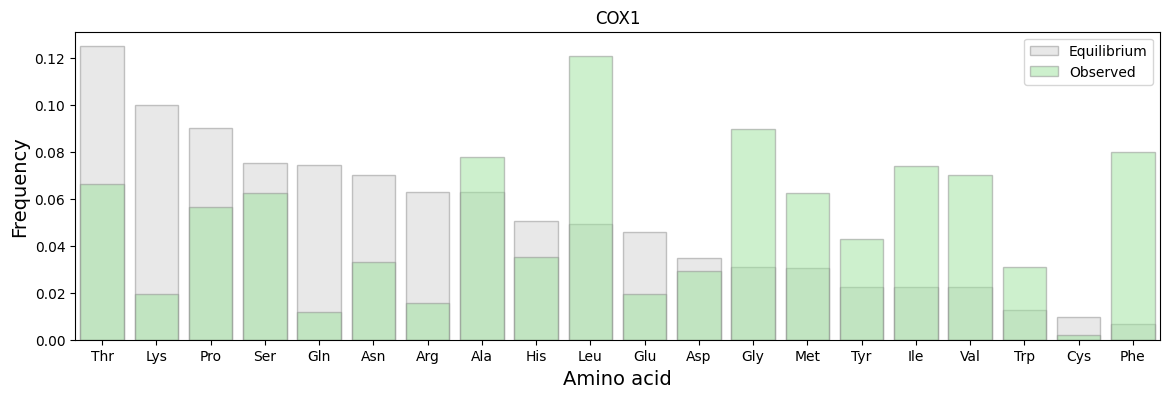

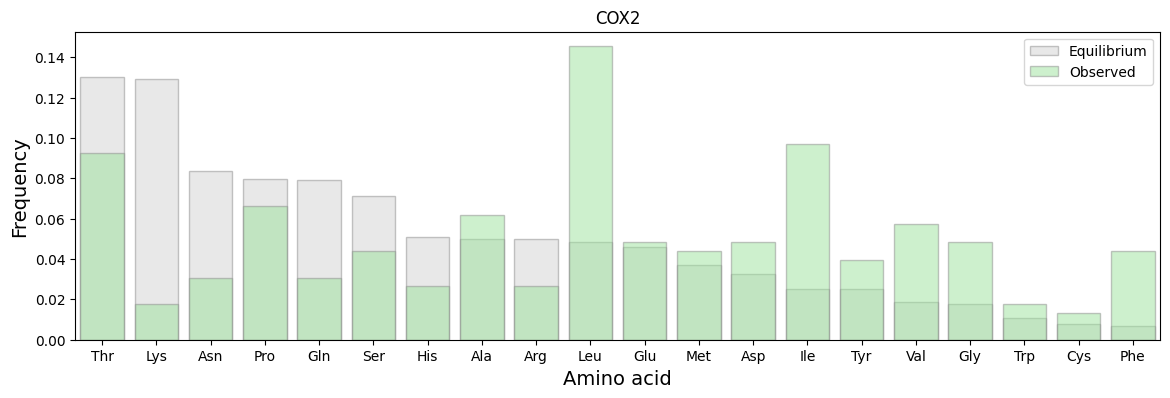

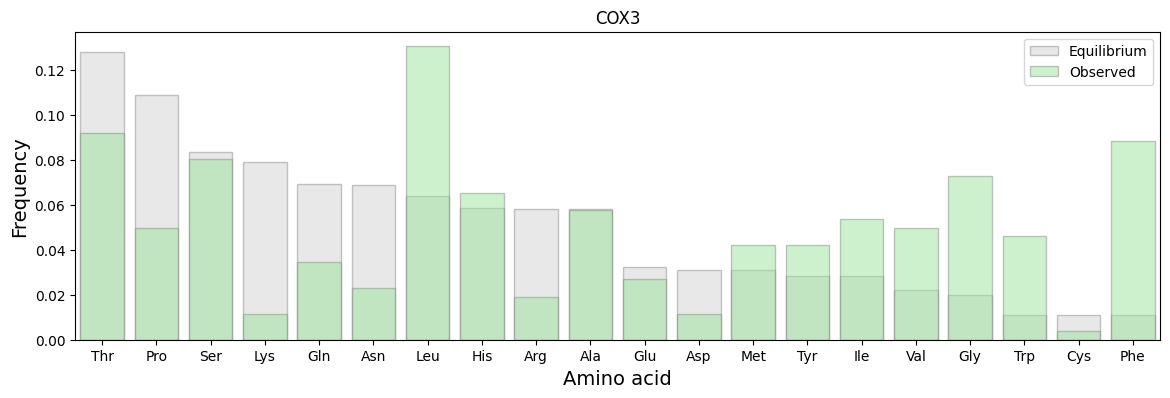

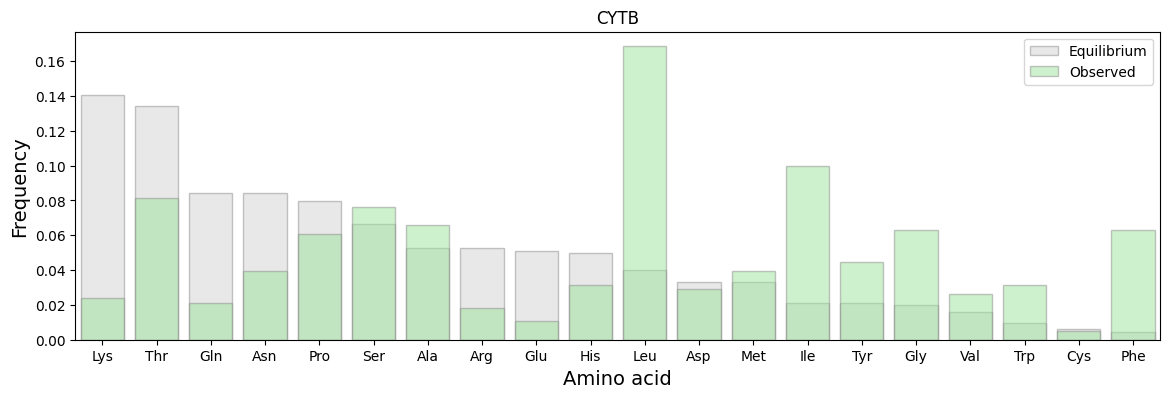

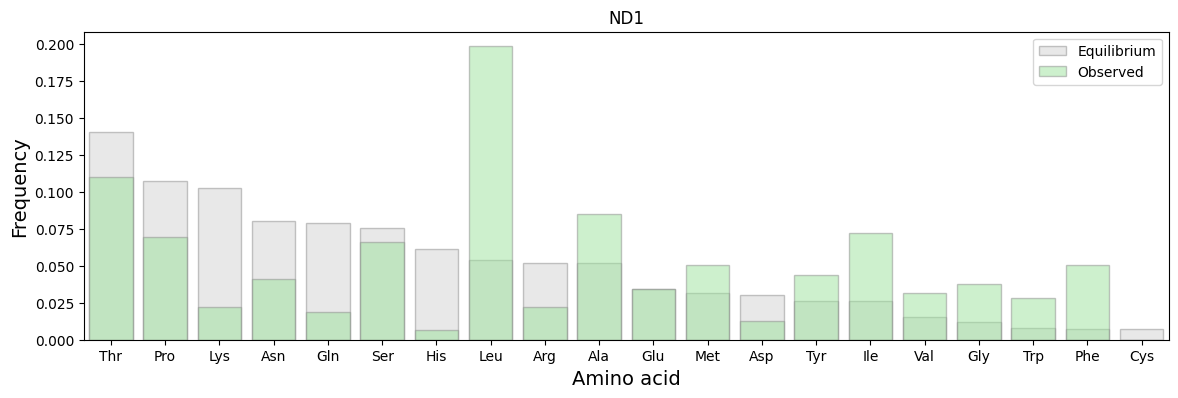

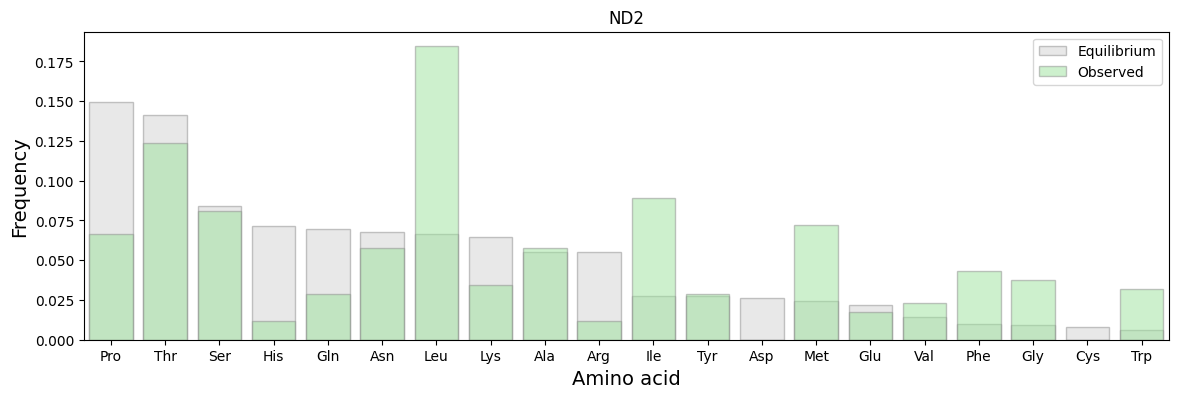

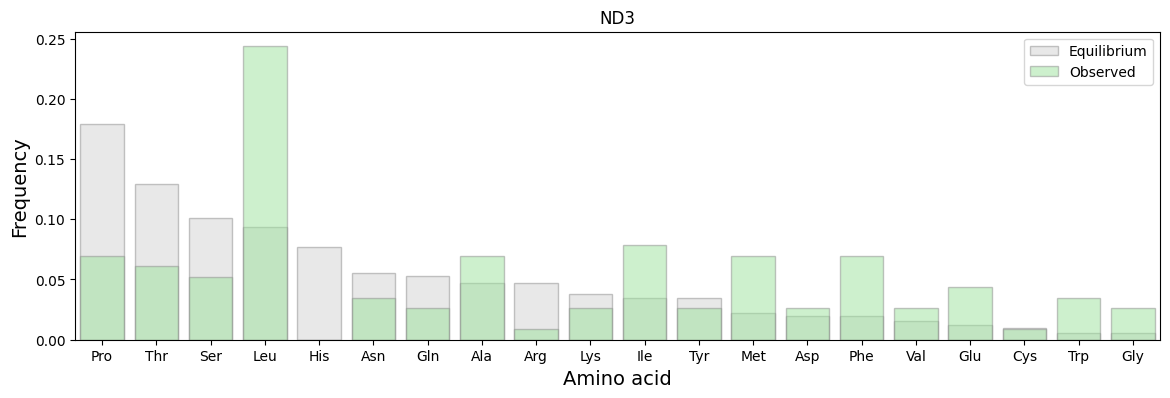

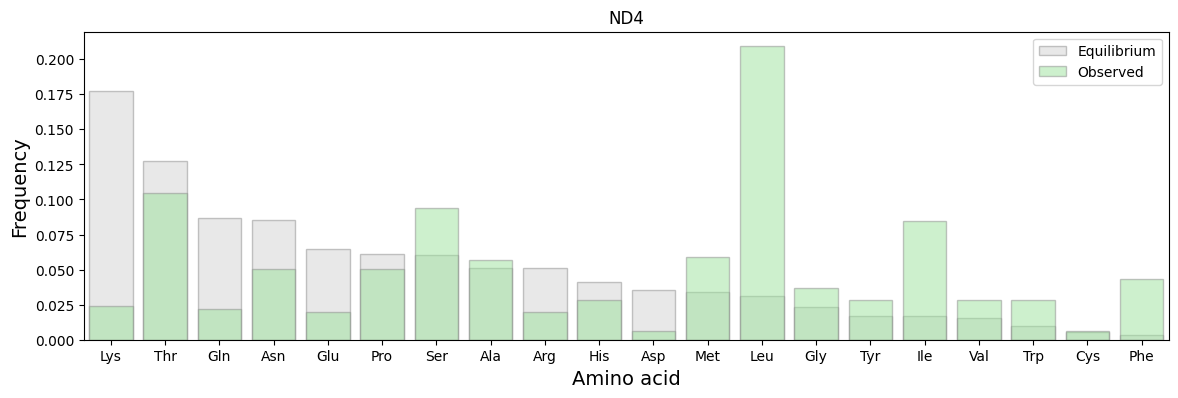

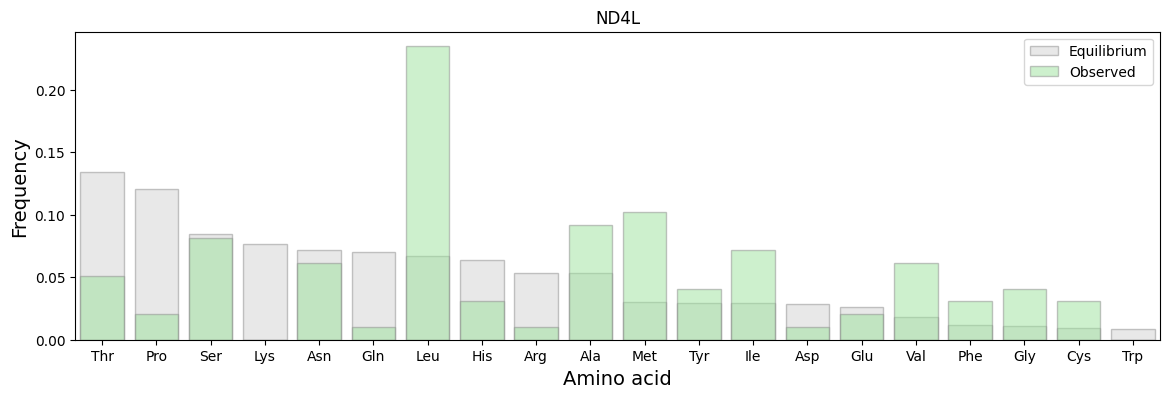

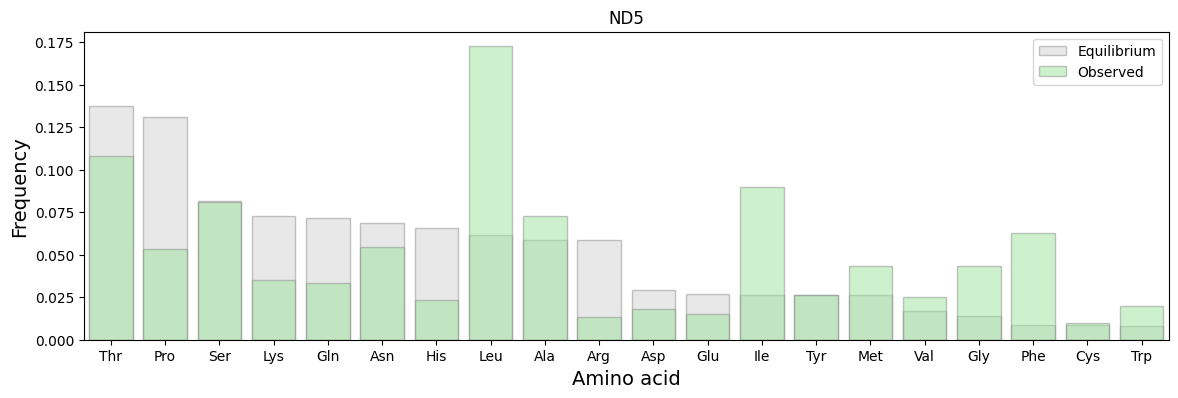

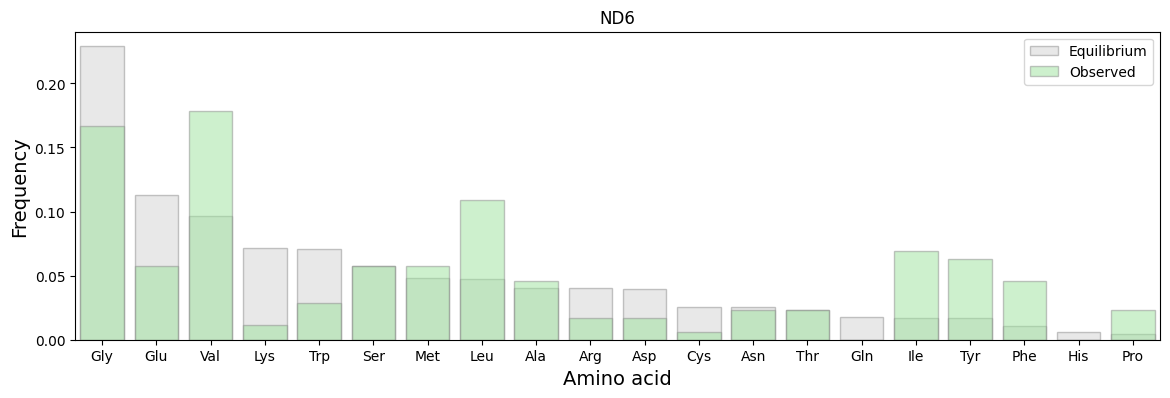

In [27]:
total_freqs = []
for gene in spectra_human_megatree.index.unique():
    _, cur_eq_aa_freqs = get_equilibrium_freqs(
        spectra_human_megatree.loc[gene], 'MutSpec', gc=2)
    cur_eq_aa_freqs.columns = ['aa', 'eq_freq']
    cur_obs_aa_freqs = aa_freqs[gene]
    cur_eq_aa_freqs['obs_freq'] = cur_eq_aa_freqs['aa'].map(
        {amino_acid_codes[x]:v for x, v in cur_obs_aa_freqs.items()}
    ).fillna(0)
    cur_eq_aa_freqs['obs_freq'] /= cur_eq_aa_freqs['obs_freq'].sum()
    cur_eq_aa_freqs['gene'] = gene
    plot_obs_vs_eq_aa_freqs(cur_eq_aa_freqs.sort_values('eq_freq', ascending=False), title=gene)
    total_freqs.append(cur_eq_aa_freqs)
total_freqs = pd.concat(total_freqs)

In [28]:
total_freqs_eq = total_freqs.pivot(index='gene', columns='aa', values='eq_freq')
total_freqs_obs = total_freqs.pivot(index='gene', columns='aa', values='obs_freq')

In [29]:
from sklearn.decomposition import PCA

# Perform PCA on total_freqs_obs
pca = PCA(n_components=2)
transformed_obs = pca.fit_transform(total_freqs_obs)

# Transform total_freqs_eq using the fitted PCA
transformed_eq = pca.transform(total_freqs_eq)

# Create a DataFrame for the transformed data
transformed_obs_df = pd.DataFrame(
    transformed_obs, columns=['PC1', 'PC2'], index=total_freqs_obs.index
)
transformed_eq_df = pd.DataFrame(
    transformed_eq, columns=['PC1', 'PC2'], index=total_freqs_eq.index
)

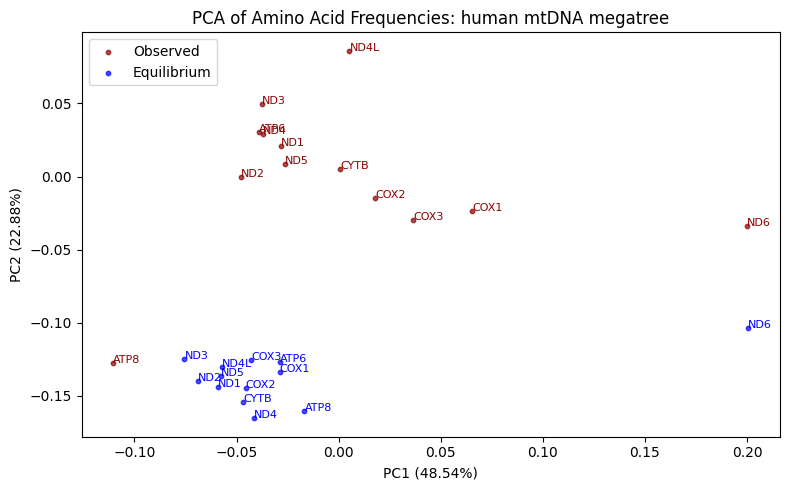

In [30]:
# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100

# Create scatterplot with labels
plt.figure(figsize=(8, 5))
plt.scatter(transformed_obs_df['PC1'], transformed_obs_df['PC2'], 
    s=10, alpha=0.7, label='Observed', color='darkred')
plt.scatter(transformed_eq_df['PC1'], transformed_eq_df['PC2'], 
    s=10, alpha=0.7, label='Equilibrium', color='blue')

# Add labels for each point
for gene, (x, y) in transformed_obs_df.iterrows():
    plt.text(x, y, gene, fontsize=8, color='darkred')
for gene, (x, y) in transformed_eq_df.iterrows():
    plt.text(x, y, gene, fontsize=8, color='blue')

# Add axis labels with explained variance
plt.title('PCA of Amino Acid Frequencies: human mtDNA megatree')
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./pca_aa_freqs_megatree.pdf', bbox_inches='tight')
plt.show()

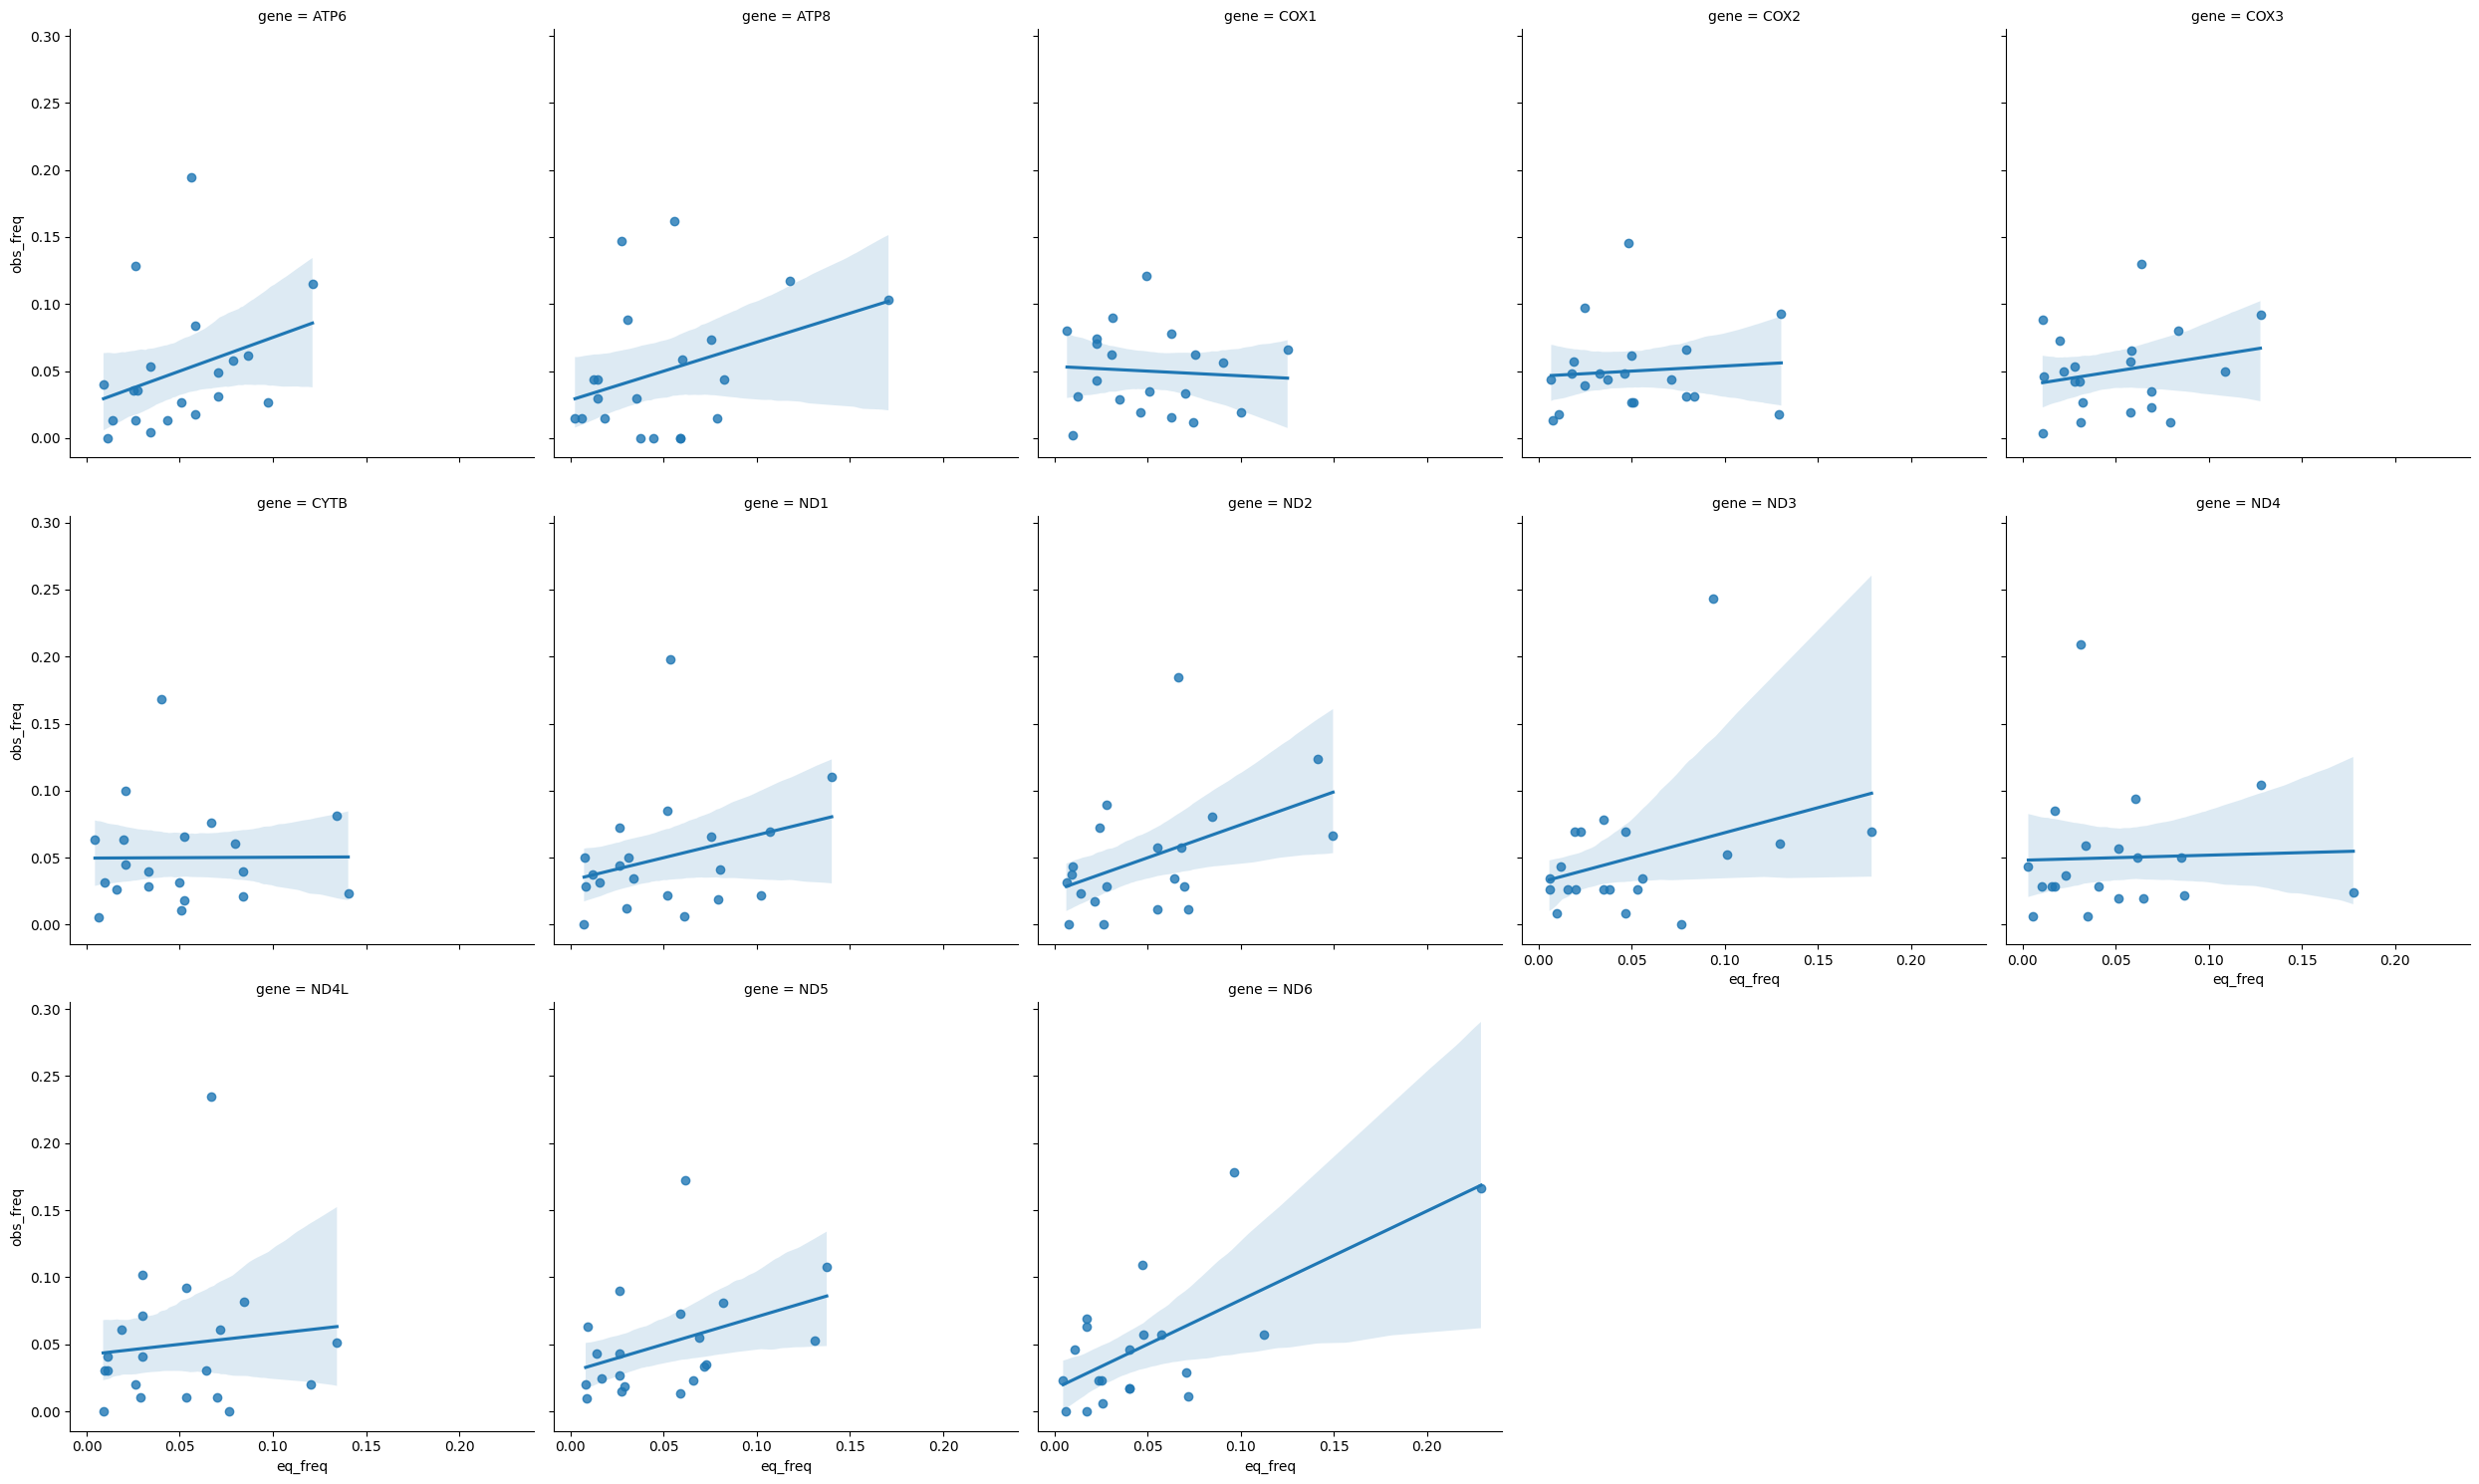

In [31]:
sns.lmplot(total_freqs, x='eq_freq', y='obs_freq', col='gene', col_wrap=5)

In [32]:
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics.pairwise import manhattan_distances

In [33]:
distances = []
for gene,cur_df  in total_freqs.groupby('gene'):
    x,y = cur_df.eq_freq.values, cur_df.obs_freq.values
    md = manhattan_distances([x], [y])[0, 0]
    ed = euclidean(x, y)
    cd = cosine(x, y)
    distances.append([gene, md, ed, cd])
distances = pd.DataFrame(distances, columns=['gene', 'manhattan', 'euclidean', 'cosine'])
distances = distances.set_index('gene')

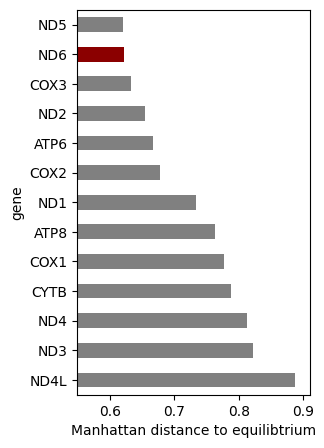

In [39]:
distances.manhattan.sort_values(ascending=False).plot.barh(
    color=['gray']*11+['darkred']+['gray'], figsize=(3, 5))
plt.xlabel('Manhattan distance to equilibtrium')
plt.xlim(0.55, 0.91)
plt.show()

## How it looks on random spectra

In [86]:
from utils import get_equilibrium_freqs_rnd, transitions
from pymutspec.draw import plot_mutspec12
import random
import pandas as pd

In [123]:
import matplotlib

my_palette = sns.diverging_palette(12, 255, s=100, sep=50, as_cmap=True)

matplotlib.colormaps.register(my_palette, name="RedBlue3")

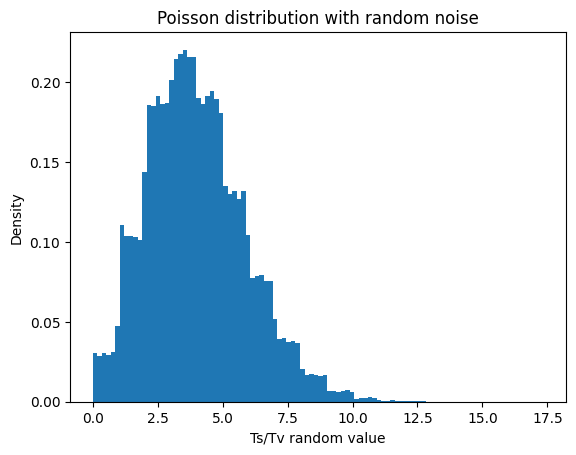

In [53]:
import matplotlib.pyplot as plt
import numpy as np

tstv_ratios = np.random.poisson(3.5, 100000) + np.random.random(100000)
plt.hist(tstv_ratios, 100, density=True)
plt.title('Poisson distribution with random noise')
plt.xlabel('Ts/Tv random value')
plt.ylabel('Density')
plt.show()

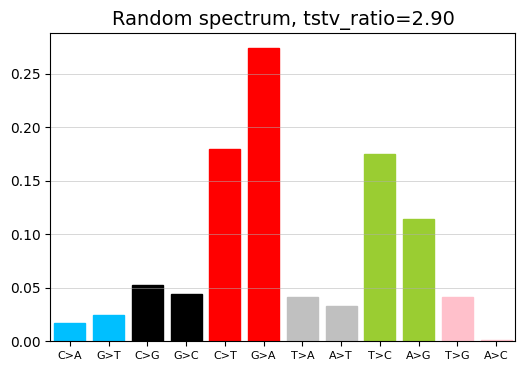

<Axes: title={'center': 'Random spectrum, tstv_ratio=2.90'}>

In [69]:
i = 1021
rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=tstv_ratios[i])
plot_mutspec12(rnd_sp, title=f'Random spectrum, tstv_ratio={tstv_ratios[i]:.2f}')

In [73]:
from warnings import filterwarnings
filterwarnings("ignore",)

In [ ]:
def get_looser_gainer_score(exp_aa_subst_matrix):
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

    _freqs_to = (freqs_to / freqs_to.sum()).copy()
    _freqs_from = (freqs_from / freqs_from.sum()).copy()
    _freqs_to.index.name = 'aa'
    _freqs_from.index.name = 'aa'

    diff = _freqs_to - _freqs_from
    return diff

In [157]:
nsamples = 100
tstv_ratios = np.random.poisson(3.5, nsamples) + np.random.random(nsamples)

random_eq_freqs = []
random_ms = []
looser_gainer_score = []
for replic, x in enumerate(tstv_ratios, 1):
    cur_tstv_ratio = round(x, 1)
    # cur_tstv_ratio = None
    rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=cur_tstv_ratio)
    rnd_sp = rnd_sp.assign(tstv_ratio=cur_tstv_ratio, replic=replic)

    _, exp_aa_subst_matrix = prepare_exp_aa_subst(rnd_sp, 'MutSpec')
    cur_looser_gainer_score = get_looser_gainer_score(exp_aa_subst_matrix)\
        .rename('flow_score').reset_index().assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    looser_gainer_score.append(cur_looser_gainer_score)
    
    rnd_eq_aa_freqs = rnd_eq_aa_freqs.assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    # one_sample = pd.concat([
    #     rnd_sp.pivot(index='tstv_ratio', columns='Mut', values='MutSpec'),
    #     rnd_eq_aa_freqs.pivot(index='tstv_ratio', columns='aa', values='eq_freq')
    # ], axis=1)
    random_eq_freqs.append(rnd_eq_aa_freqs)
    random_ms.append(rnd_sp)

random_eq_freqs = pd.concat(random_eq_freqs, ignore_index=False)
random_ms = pd.concat(random_ms, ignore_index=False)
looser_gainer_score = pd.concat(looser_gainer_score, ignore_index=False)

In [158]:
random_ms.tstv_ratio.describe()

count    1200.000000
mean        3.935000
std         1.696842
min         0.500000
25%         2.675000
50%         4.000000
75%         4.875000
max         8.700000
Name: tstv_ratio, dtype: float64

Text(0.5, 1.0, 'Loser-Gainer score distribution on random spectra')

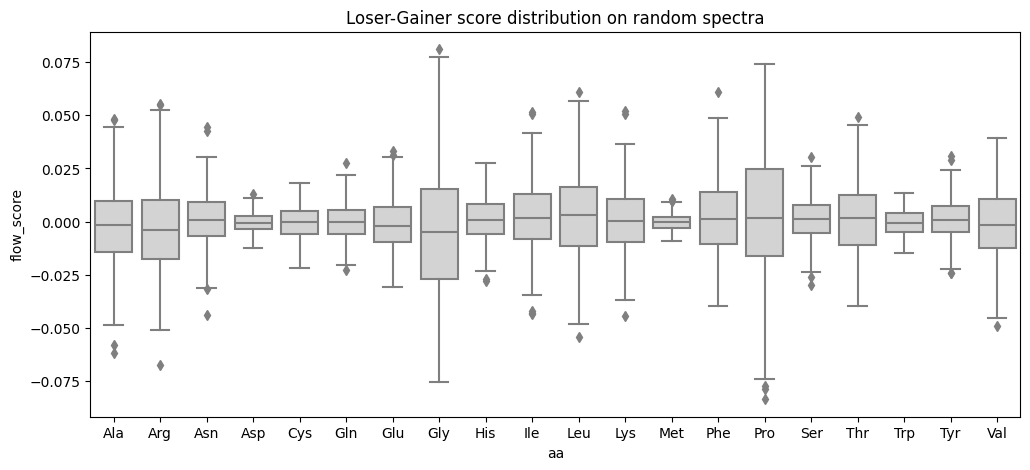

In [153]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(
    looser_gainer_score, 
    # order=looser_gainer_score.groupby('aa').flow_score.mean().sort_values(ascending=False).index,
    x='aa', y='flow_score', 
    color='lightgray',
    # palette='RedBlue3', 
#     edgecolor=".65"
)
ax.set_title('Loser-Gainer score distribution on random spectra')

<Axes: xlabel='aa', ylabel='eq_freq'>

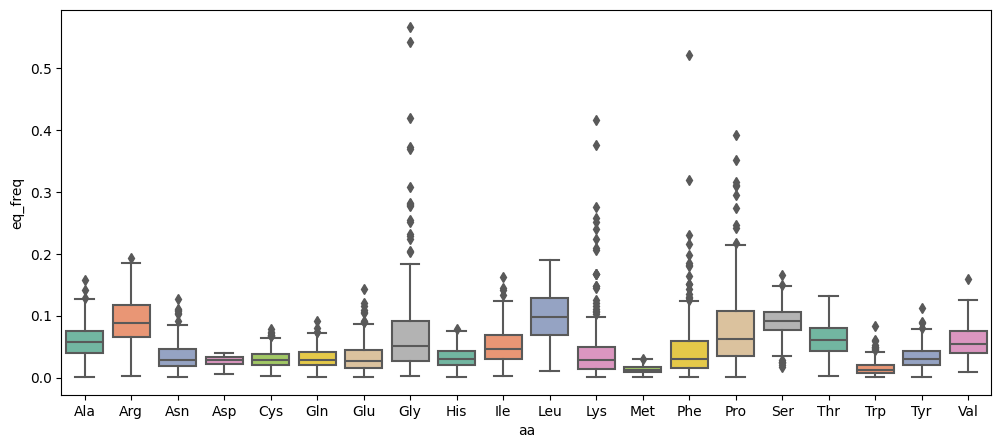

In [154]:
plt.figure(figsize=(12, 5))
sns.boxplot(random_eq_freqs, x='aa', y='eq_freq',
            palette='Set2', order=sorted(random_eq_freqs.aa.unique()))

<Axes: xlabel='Mut', ylabel='MutSpec'>

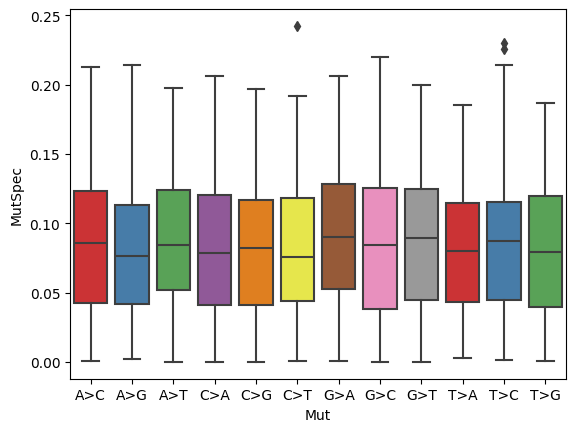

In [155]:
sns.boxplot(random_ms, x='Mut', y='MutSpec',
            palette='Set1', )